In [1]:
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm
import pickle
import copy
import sys
from os import path
import matplotlib.pyplot as plt
from factoreg import *

device = 'cpu'

In [2]:
data = pd.read_csv('data/data_v2.csv')
data['logS'] = np.log10(data['#Params (B)'])
data['logT'] = np.log10(data['Pretraining Data Size (T)'])
data['logSlogT'] = data['logS']*data['logT']
data['logS2'] = data['logS']**2
data['logT2'] = data['logT']**2
data['GreatFamily'] = data['Family']
data['Family'] = data['Family2']
X_names = ['logS','logT','logSlogT'] #

Y_names = ['MMLU',
           'ARC',
           'HellaSwag',
           'Winogrande',
           'TruthfulQA',
           'GSM8K',
           'IFEval',
           'BBH',
           'MATH Lvl 5',
           'GPQA',
           'MUSR',
           'MMLU-PRO']
data = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names].dropna()
data.head()

,Model,Family,GreatFamily,Instruct,logS,logT,logSlogT,MMLU,ARC,HellaSwag,Winogrande,TruthfulQA,GSM8K,IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO
1,bloom-1b1,bloom,bloom,False,0.000000,-0.467246,-0.000000,0.267021,0.283276,0.427803,0.550118,0.417972,0.002274,0.14,0.31,0.00,0.26,0.37,0.11
2,bloom-3b,bloom,bloom,False,0.477121,-0.467246,-0.222933,0.265925,0.357509,0.543716,0.576164,0.405725,0.015163,0.13,0.31,0.00,0.24,0.40,0.11
3,bloom-560m,bloom,bloom,False,-0.251812,-0.467246,0.117658,0.242154,0.247440,0.371540,0.519337,0.424443,0.003033,0.06,0.30,0.00,0.26,0.40,0.12
4,bloom-7b1,bloom,bloom,False,0.845098,-0.467246,-0.394868,0.262462,0.411263,0.619996,0.654301,0.388978,0.013647,0.13,0.31,0.00,0.26,0.35,0.11
5,blossom-v5.1-34b,blossom-v5.1,yi-1.5,True,1.531479,0.544068,0.833229,0.780500,0.675800,0.858300,0.834300,0.618400,0.655800,0.57,0.61,0.14,0.31,0.39,0.45


#ind = (X[:,0]==0).numpy()
#ind.shape

#X = X[ind]
#X = X[:,1:]
#Y = Y[ind]
#D = D[ind]

In [3]:
D = np.array(pd.get_dummies(np.array(data.Family))).astype(float)
X = np.array(data.loc[:,X_names]).astype(float)
Y = np.array(data.loc[:,Y_names]).astype(float)

Cs = []
for s in Y_names:
    Cs.append(pd.read_csv('data/lower_bounds.csv')[s].iloc[0])
Cs = np.array(Cs).astype(float)[None,:]

In [4]:
d=4
model = FactorRegression(d)
model.fit(X, D, Y, Cs, train_link=False, positive_w=True, verbose=True)
model.best_loss

  0%|          | 0/100000 [00:00<?, ?it/s]

0.09999999999999999 0.020358992740511894


  0%|          | 0/100000 [00:00<?, ?it/s]

0.03162277660168379 0.020373059436678886


  0%|          | 0/100000 [00:00<?, ?it/s]

0.01 0.020381024107336998


  0%|          | 0/100000 [00:00<?, ?it/s]

0.0031622776601683794 0.020390087738633156


  0%|          | 0/100000 [00:00<?, ?it/s]

0.001 0.020401006564497948


0.020358992740511894

In [5]:
model.a2, model.b2

(tensor([[0.8257, 0.5807, 0.6423, 0.6228, 0.5529, 1.4245, 1.1261, 1.0073, 1.3006,
          0.7337, 0.2658, 0.9427]]),
 tensor([[ 0.4339,  0.0999,  0.9715, -0.0723, -0.1965, -1.1847, -1.1347, -1.1579,
          -3.8784, -2.8538, -1.1531, -1.1629]]))

In [6]:
model2 = FactorRegression(d)
model2.fit(X, D, Y,
           C0=model.C.numpy(),
           W1_X0=model.W1_X.numpy(),
           W1_D0=model.W1_D.numpy(),
           W20=model.W2.numpy(),
           a20=model.a2.numpy(),
           b20=model.b2.numpy(),
           train_link=True,
           positive_w=True, 
           verbose=True)
model2.best_loss

  0%|          | 0/100000 [00:00<?, ?it/s]

0.09999999999999999 0.01786472648382187


  0%|          | 0/100000 [00:00<?, ?it/s]

0.03162277660168379 0.013585361652076244


  0%|          | 0/100000 [00:00<?, ?it/s]

0.01 0.013483008369803429


  0%|          | 0/100000 [00:00<?, ?it/s]

0.0031622776601683794 0.014231940731406212


  0%|          | 0/100000 [00:00<?, ?it/s]

0.001 0.013757258653640747


0.013483008369803429

factor_labels = ['Knowledge-based\nreasoning',
                 'Mathematical\nreasoning','Instruction\nfollowing']

In [7]:
factor_labels = ['a','b','c','d']

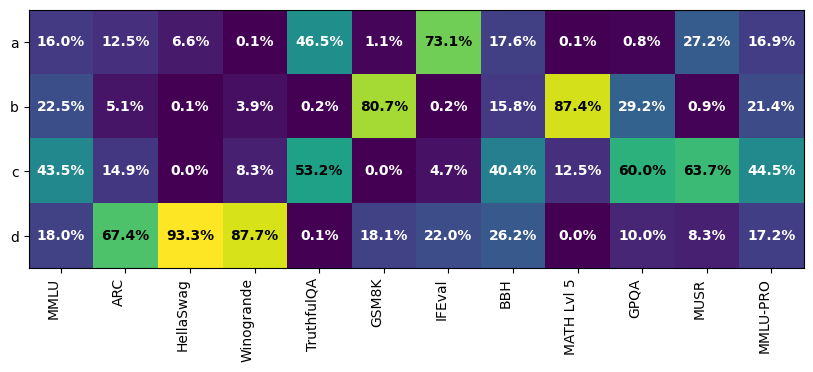

In [8]:
M = model.W2.detach().numpy()

plt.figure(figsize=(10, 6))  # Set the figure size (width, height) in inches

plt.imshow(M)
plt.xticks(np.arange(len(Y_names)), labels=Y_names, rotation=90, ha="right")  # Set the x-tick labels
plt.yticks(np.arange(d), labels=factor_labels, rotation=0, ha="right")  # Set the y-tick labels

threshold = 50  # Set your threshold value here
for i in range(len(M)):
    for j in range(len(M.T)):
        value = 100 * M[i, j]
        color = "black" if value > threshold else "white"  # Conditional color
        text = plt.text(j, i, f'{value:.1f}%', size=10, ha="center", va="center", color=color, weight='bold')#

plt.show()


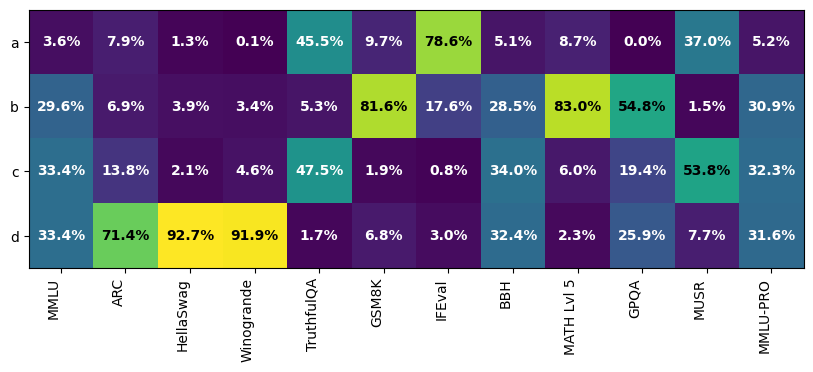

In [9]:
M = model2.W2.detach().numpy()

plt.figure(figsize=(10, 6))  # Set the figure size (width, height) in inches

plt.imshow(M)
plt.xticks(np.arange(len(Y_names)), labels=Y_names, rotation=90, ha="right")  # Set the x-tick labels
plt.yticks(np.arange(d), labels=factor_labels, rotation=0, ha="right")  # Set the y-tick labels

threshold = 50  # Set your threshold value here
for i in range(len(M)):
    for j in range(len(M.T)):
        value = 100 * M[i, j]
        color = "black" if value > threshold else "white"  # Conditional color
        text = plt.text(j, i, f'{value:.1f}%', size=10, ha="center", va="center", color=color, weight='bold')#

plt.savefig(f'plots/loadings.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()

In [30]:
np.round((model.W1_X).detach().numpy()/model.Z1.numpy().std(0)[None,:],3)

array([[1.234e+00, 3.560e-01, 6.500e-02],
       [1.464e+00, 6.400e-02, 2.980e-01],
       [2.400e-02, 1.000e-03, 1.300e-02]], dtype=float32)

In [31]:
np.round((model2.W1_X).detach().numpy()/model2.Z1.numpy().std(0)[None,:],3)

array([[1.031, 0.53 , 0.262],
       [0.058, 0.024, 0.234],
       [0.391, 0.051, 0.297]], dtype=float32)

In [32]:
families_inst = ['falcon-instruct', 'gemma-it', 'llama-2-chat', 'meta-llama-3-instruct',
 'qwen1.5-chat','recurrentgemma-it', 'yi-1.5-chat']
families = ['falcon', 'gemma', 'llama-2', 'meta-llama-3',
 'qwen1.5','recurrentgemma', 'yi-1.5']

skills = model2.Z1.numpy()
skills = (skills-skills.mean(0))/skills.std(0)
effects={}
for family,family_inst in zip(families, families_inst):
    sizes =  np.unique(data.loc[(np.array(data['Family']==family_inst))].logS)
    effects[family] = []
    for size in sizes:
        select = np.zeros((data.shape[0],1))
        ind1 = np.argmax(np.array(data['Family']==family_inst) * np.array(data['logS']==size))
        ind2 = np.argmax(np.array(data['Family']==family) * np.array(data['logS']==size))
        
        effects[family].append([skills[ind1].tolist(),skills[ind2].tolist()])
    effects[family] = np.array(effects[family])
#effects

In [33]:
effects['yi-1.5'].shape

(3, 2, 3)

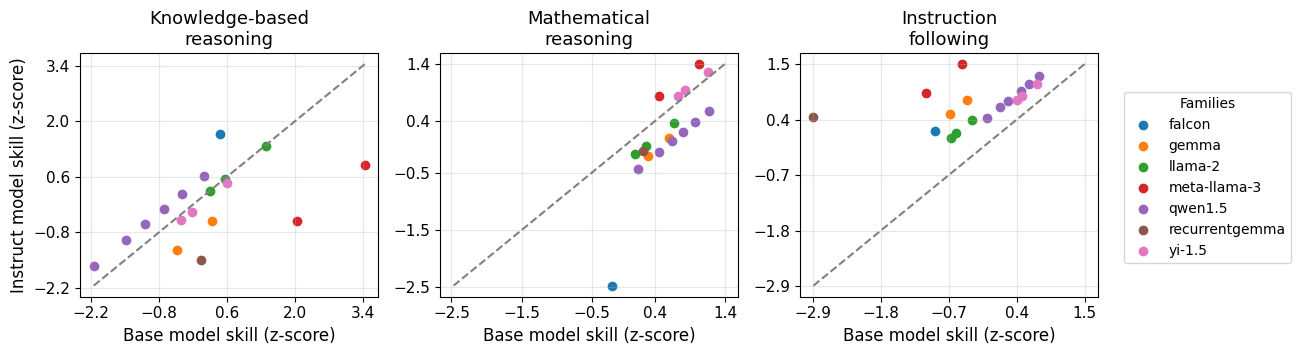

In [34]:
n_skills = effects[family].shape[-1]  # Number of skills
fig, axs = plt.subplots(1, n_skills, figsize=(13, 3.65))  # Adjust size as needed , sharex=True, sharey=True

for skill in range(n_skills):
    ax = axs[skill]
    
    # Determine min/max for the current skill across all families
    min_val = np.min([ef[:, :, skill].min() for ef in effects.values()])
    max_val = np.max([ef[:, :, skill].max() for ef in effects.values()])

    # Plot data for each family
    for family in effects.keys():
        ax.scatter(effects[family][:, 1, skill], effects[family][:, 0, skill], label=family)
    
    ax.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--')  # Diagonal line
    
    ax.set_title(factor_labels[skill], size=13)
    ax.set_xlabel('Base model skill (z-score)', size=12)
    if skill == 0:  # Only set y-label on the first subplot
        ax.set_ylabel('Instruct model skill (z-score)', size=12)

    # Create a common set of ticks for both axes
    ticks = np.linspace(min_val, max_val, num=5)  # Adjust `num` for more or fewer ticks
    ticks = np.round(ticks, 1)
    
    # Set the same ticks for both x and y axes
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    ax.tick_params(axis='both', which='major', labelsize=11)  # Change major tick size
    #ax.tick_params(axis='both', which='minor', labelsize=10)  # Change minor tick size
    ax.grid(alpha=.3)
    
# Add a shared legend on the right
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title="Families")

plt.tight_layout(rect=[0, 0, .86, 1])  # Adjust the layout to make room for the legend
plt.savefig(f'plots/it.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()

In [35]:
skill = 1

In [36]:
def f(x, y, w):
    return np.log(x)*w[0] + np.log(y)*w[1] + np.log(x)*np.log(y)*w[2]

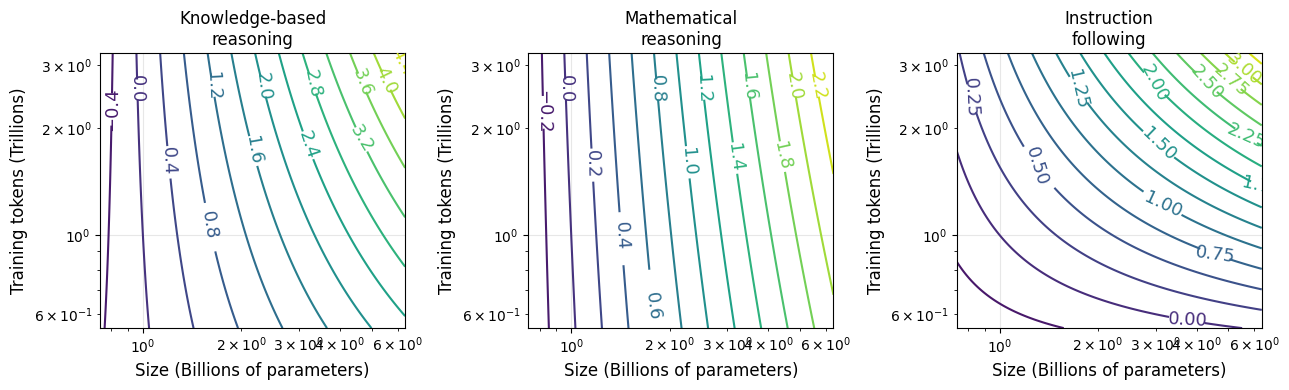

In [39]:
W = model2.W1_X.numpy()
n_skills = W.shape[-1]

# Create a figure and an array of subplots
fig, axs = plt.subplots(1, n_skills, figsize=(13, 4))  # Adjust figsize for side-by-side display

for skill in range(n_skills):
    w = W[:,skill]
    
    # Create a grid of x and y values
    bins = 100
    perc_min = np.percentile(X, 5, axis=0)
    perc_max = np.percentile(X, 95, axis=0)
    s = np.exp(np.linspace(perc_min[0], perc_max[0], bins))
    t = np.exp(np.linspace(perc_min[1], perc_max[1], bins))
    S, T = np.meshgrid(s, t)
    
    # Compute the function values over the grid
    Z = f(S, T, w)
    
    # Plot the level curves (contour plot)
    contour = axs[skill].contour(S, T, Z, levels=15, cmap='viridis')
    axs[skill].clabel(contour, inline=True, fontsize=13)
    axs[skill].set_title(factor_labels[skill])
    axs[skill].set_xlabel('Size (Billions of parameters)', size=12)
    axs[skill].set_ylabel('Training tokens (Trillions)', size=12)
    axs[skill].set_xscale('log')
    axs[skill].set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=11)  # Change major tick size
    axs[skill].grid(alpha=0.3)

# Adjust the layout to prevent overlap
plt.tight_layout()

plt.savefig(f'plots/level-curves.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()
